In [1]:
import os
import cv2
import time
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization



print ('modules loaded')

modules loaded


In [2]:

df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df.head(3)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1


In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
print("done")

done


In [4]:
def has_DR(dignosis):
    if dignosis==0:
        return 0
    else:
        return 1
df["DR"] = df["diagnosis"].apply(lambda x: has_DR(x))

DR = df.loc[(df.DR == 1)]["id_code"].values

normal=df.loc[(df.DR == 0)]["id_code"].values
print(DR[:5])

['000c1434d8d7' '001639a390f0' '0024cdab0c1e' '0083ee8054ee'
 '00a8624548a9']


In [ ]:
print(len(DR),len(normal))


In [5]:

dataset_dir = "/kaggle/input/aptos2019-blindness-detection/train_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    i=0
    for img in tqdm(image_category):
        if i <1400:
            image_path = os.path.join(dataset_dir,img+'.png')
        
            imge = cv2.imread(image_path)
            
            # Blur the image
            blurred = cv2.blur(imge, ksize=(15, 15))

# Take the difference with the original image
# Weight with a factor of 4x to increase contrast
            dst = cv2.addWeighted(imge, 4, blurred, -4, 128)
            lab = cv2.cvtColor(dst, cv2.COLOR_BGR2LAB)
            lab_planes = list(cv2.split(lab))
            gridsize = 5
            clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
            lab_planes[0] = clahe.apply(lab_planes[0])
            lab = cv2.merge(lab_planes)
            bgr2 =crop_image_from_gray(lab)
            bgr2 = cv2.cvtColor(bgr2, cv2.COLOR_LAB2BGR)
            bgr2 = cv2.resize(bgr2,(image_size,image_size))
            image=np.array(bgr2)/255
        
        
            dataset.append([np.array(image),np.array(label)])
            i+=1
    random.shuffle(dataset)
    return dataset
        



In [6]:
dataset = create_dataset(DR,1)
len(dataset)

100%|██████████| 1857/1857 [09:25<00:00,  3.28it/s]


1400

In [7]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 1805/1805 [03:55<00:00,  7.68it/s]


2800

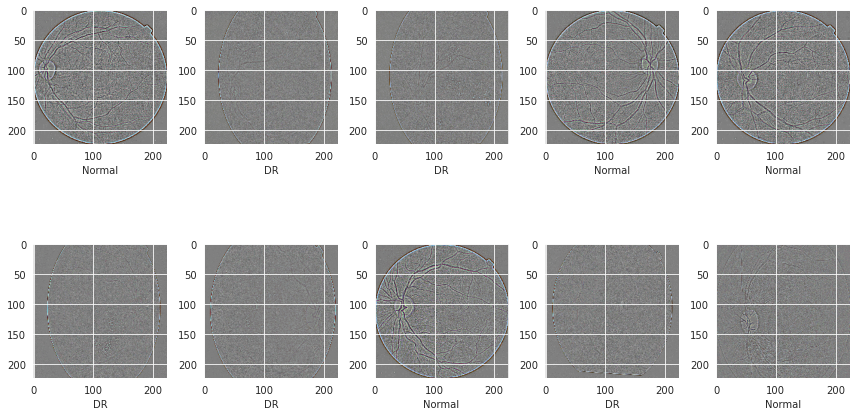

In [8]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "DR"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [9]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])



#x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.1)
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)
x_train = x[:int(len(x)*.9)]
y_train = y[:int(len(y)*.9)]
x_test = x[int(len(x)*.9):]
y_test =y[int(len(y)*.9):]

x_train = x_train[:int(len(x_train)*.9)]
y_train = y_train[:int(len(y_train)*.9)]

x_valid = x_train[int(len(x_train)*.9):]
y_valid =y_train[int(len(y_train)*.9):]


In [10]:

datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                            fill_mode='constant', cval=0.)
train_gen = datagen.flow(x_train, y_train, batch_size=32)

In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2, l1
# Basic architecture model of InceptionV3
model_inception=InceptionV3(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
x=model_inception.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
output=Dense(1,kernel_regularizer = tf.keras.regularizers.L2(0.01) ,activation='sigmoid')(x) #FC-layer
model_inception=tf.keras.Model(inputs=model_inception.input,outputs=output)
model_inception.summary()
# Freezing the base model
for layer in model_inception.layers[:-5]:
    layer.trainable=False

2023-01-28 22:29:08.616429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:29:08.617503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:29:08.737872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:29:08.738776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:29:08.739744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model_inception.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
import tensorflow as tf
from tensorflow.python.ops import histogram_ops


#mc_filepath="/content/gdrive/MyDrive/gp/Cataract/callbacks/weights/weights-improvment-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#mc_callback = tf.keras.callbacks.ModelCheckpoint(mc_filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

#csv_callback= tf.keras.callbacks.CSVLogger('/content/gdrive/MyDrive/gp/Cataract/callbacks/my_train.csv',separator=',',append=False)
#tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/MyDrive/gp/Cataract/callbacks',histogram_freq=1,write_graph=True,write_images=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=15, verbose=1)

2023-01-28 22:29:15.315992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-28 22:29:21.442086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8854

2023-01-28 22:29:53.866885: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 136679424 exceeds 10% of free system memory.
2023-01-28 22:29:54.115762: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 136679424 exceeds 10% of free system memory.


71/71 [==============================] - 41s 384ms/step - loss: 0.4117 - accuracy: 0.8854 - val_loss: 0.2935 - val_accuracy: 0.9075
Epoch 2/100
71/71 [==============================] - 25s 346ms/step - loss: 0.3440 - accuracy: 0.9092 - val_loss: 0.2317 - val_accuracy: 0.9075
Epoch 3/100
71/71 [==============================] - 24s 341ms/step - loss: 0.2820 - accuracy: 0.9131 - val_loss: 0.2075 - val_accuracy: 0.9383
Epoch 4/100
71/71 [==============================] - 25s 346ms/step - loss: 0.2837 - accuracy: 0.9198 - val_loss: 0.2130 - val_accuracy: 0.9163
Epoch 5/100
71/71 [==============================] - 24s 336ms/step - loss: 0.2272 - accuracy: 0.9242 - val_loss: 0.1942 - val_accuracy: 0.9471
Epoch 6/100
71/71 [==============================] - 24s 340ms/step - loss: 0.2472 - accuracy: 0.9242 - val_loss: 0.1992 - val_accuracy: 0.9339
Epoch 7/100
71/71 [==============================] - 24s 343ms/step - loss: 0.2142 - accuracy: 0.9308 - val_loss: 0.1905 - val_accuracy: 0.9383
Epoc

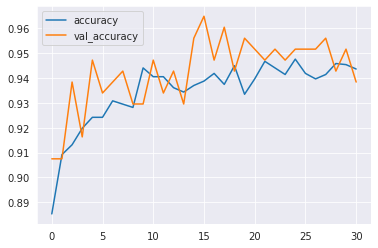

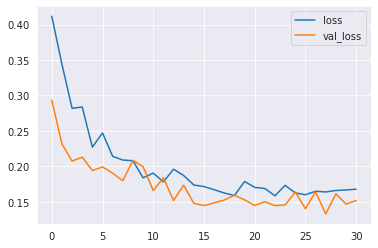

In [14]:

history = model_inception.fit(train_gen, 
                    epochs=100,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(x_valid,y_valid),
                    verbose=1)


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [15]:
loss,accuracy = model_inception.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

2023-01-28 22:42:07.877103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 168591360 exceeds 10% of free system memory.
2023-01-28 22:42:08.233132: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 168591360 exceeds 10% of free system memory.


9/9 [==============================] - 2s 211ms/step - loss: 0.1903 - accuracy: 0.9500
loss: 0.1903160959482193
Accuracy: 0.949999988079071


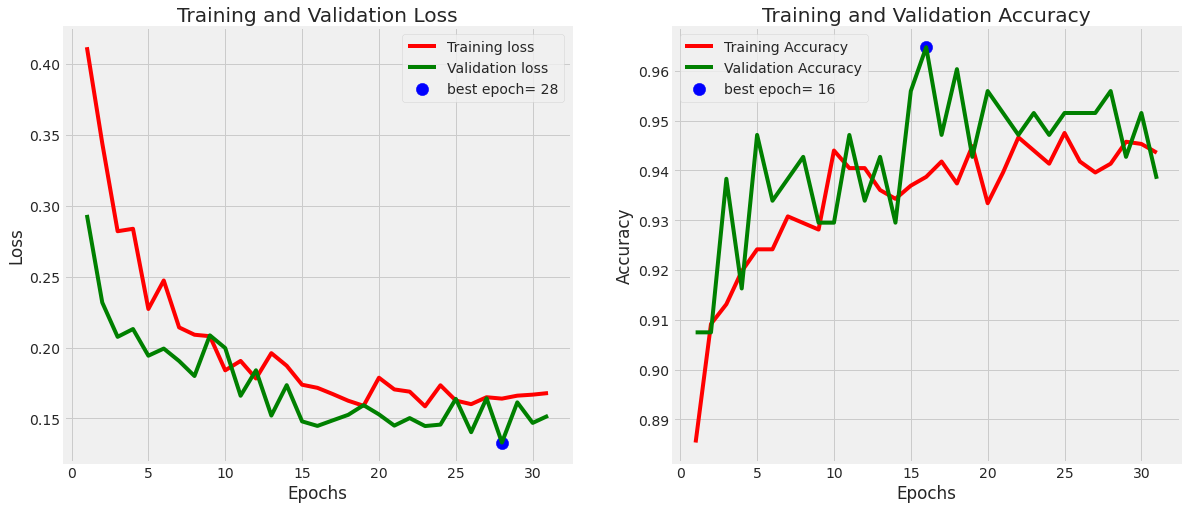

In [16]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

plot_training(history)

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model_inception.predict(x_test)
accuracy_score(y_test,y_pred.round())
print(classification_report(y_test,y_pred.round()))

2023-01-28 22:42:21.987933: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 168591360 exceeds 10% of free system memory.


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       140
           1       0.96      0.94      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



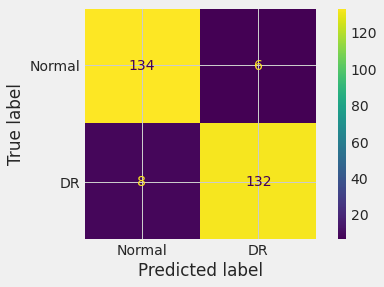

In [18]:

import numpy
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal","DR"])

cm_display.plot()
plt.show()


In [19]:
from sklearn.metrics import accuracy_score
model_name = 'inception'
subject = 'DR_classification'
acc = accuracy * 100
save_path = '/kaggle/working/'

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model_inception.save(model_save_loc)
print(f'model was saved as {model_save_loc}')


model was saved as /kaggle/working/inception-DR_classification-95.00.h5
